# Project Overview

This project focuses on classifying wine reviews based on their quality, specifically whether they receive a rating of 90 points or higher. The goal is to build and train machine learning models that can automatically classify wine reviews as either "high-quality" or not. The project utilizes a dataset containing wine descriptions, points, prices, and other relevant information.

## Key Steps

1. **Data Preprocessing**: The dataset is loaded, and unnecessary columns are removed to focus on essential features such as descriptions and labels. The labels are derived from wine ratings, with reviews receiving 90 points or higher considered as "high-quality."

2. **Data Splitting**: The dataset is split into training, validation, and test sets to facilitate model training and evaluation.

3. **Text Vectorization**: Two different approaches to text processing are explored. The first approach uses pre-trained word embeddings from TensorFlow Hub (nnlm-en-dim50/2), while the second utilizes an LSTM-based neural network. Text vectorization and tokenization are performed to prepare the textual data for modeling.

4. **Model Building**: Two distinct models are created. The first model incorporates pre-trained word embeddings, followed by dense layers. The second model uses an LSTM layer for sequence processing. Both models are designed to predict the binary label (high-quality or not) for wine reviews.

5. **Model Training and Evaluation**: The models are trained and evaluated on the training and validation datasets. Training progress, including accuracy and loss, is monitored for each model.

In [1]:
# Importing essential libraries for data manipulation, visualization and modeling

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub

In [2]:
# Reading in the dataset

df = pd.read_csv('wine-reviews.csv')

In [3]:
df.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [4]:
df.shape

(129971, 14)

In [5]:
df = df[['country', 'description', 'points', 'price', 'variety', 'winery']]

In [6]:
df.head()

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


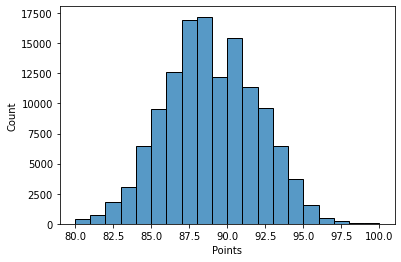

In [7]:
# Visualizing the distribution of wine review scores ('points')

fig = sns.histplot(data=df, x='points', bins=20)
plt.xlabel('Points')
plt.show()

In [8]:
# Creating a binary 'label' column based on a condition to be used as the target variable.

df['label'] = (df.points >= 90).astype(int)
df = df[['description','label']]

In [9]:
df.head()

,description,label
0,"Aromas include tropical fruit, broom, brimston...",0
1,"This is ripe and fruity, a wine that is smooth...",0
2,"Tart and snappy, the flavors of lime flesh and...",0
3,"Pineapple rind, lemon pith and orange blossom ...",0
4,"Much like the regular bottling from 2012, this...",0


In [10]:
# Splitting the data

train, val, test = np.split(df.sample(frac=1), [int(0.8*len(df)), int(0.9*len(df))])

In [11]:
len(train), len(val), len(test)

(103976, 12997, 12998)

In [12]:
def df_to_dataset(dataframe, shuffle=True, batch_size=1024):
    """
    Convert pandas df to TensorFlow dataset
    """
    
    df = dataframe.copy()
    labels = df.pop('label')
    df = df['description']
    ds = tf.data.Dataset.from_tensor_slices((df, labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

In [13]:
# Converting the split dataframes into TensorFlow datasets

train_data = df_to_dataset(train)
valid_data = df_to_dataset(val)
test_data = df_to_dataset(test)

In [14]:
# First batch of train_data

list(train_data)[0]

(<tf.Tensor: shape=(1024,), dtype=string, numpy=
 array([b"While bolder in body and a more brambly and earthy than the 2015, Grafen Neipperg's Trollinger is attractive for its crisp sour cherry and plum flavors. Brisk acidity and soft, feathery tannins linger nicely on the finish. Drink now.",
        b'A small, husband-and-wife project inspired by the late Greg Brown of T-Vine Cellars, who made some mighty fine wines in his day, this wine is waxy in plum and blackberry, fruity yet possessed of equal parts cedar and herb. Full bodied, it retains plenty of acidity, balanced in approach and price.',
        b"This is a fruity, fresh, forward wine that has delicious red berry fruitiness and soft tannins. It's bright and smooth, the structure just lightly supporting the fruit. It's ready to drink.",
        ...,
        b'For an inaugural effort, this coastal Pinot Noir is on the money. Dark and slightly charred-smelling on the nose, the wine is not shy. Full, oaky and moderately tannic, i

In [15]:
train_batches = tf.data.experimental.cardinality(train_data).numpy()
valid_batches = tf.data.experimental.cardinality(valid_data).numpy()
test_batches = tf.data.experimental.cardinality(test_data).numpy()

print("Train Batches:", train_batches)
print("Valid Batches:", valid_batches)
print("Test Batches:", test_batches)

Train Batches: 102
Valid Batches: 13
Test Batches: 13


## Leveraging Text Embedding for Model Construction


In [16]:
# Initialize a KerasLayer with text embeddings from TensorFlow Hub.

embedding = 'https://tfhub.dev/google/nnlm-en-dim50/2'

hub_layer = hub.KerasLayer(embedding, dtype=tf.string, trainable=True)

In [17]:
# Obtain text embeddings for the first batch of training data.

hub_layer(list(train_data)[0][0])

<tf.Tensor: shape=(1024, 50), dtype=float32, numpy=
array([[ 0.49141955, -0.08587736,  0.11341967, ..., -0.07416604,
        -0.17615455,  0.14057806],
       [ 0.47379652, -0.10962442,  0.05096427, ..., -0.09658384,
        -0.37303904, -0.01706004],
       [ 0.34575176, -0.36578158, -0.10732725, ..., -0.16232002,
         0.15332471,  0.16425791],
       ...,
       [ 0.36813903,  0.05223183,  0.12846713, ..., -0.11695352,
        -0.00501289, -0.01595003],
       [ 0.60069627, -0.2966222 , -0.00427842, ...,  0.26246175,
        -0.00920041, -0.04994629],
       [ 0.17683543, -0.38557753, -0.05432156, ...,  0.11989411,
        -0.11701676,  0.00459582]], dtype=float32)>

In [18]:
# Create a Sequential model with Hub Layer, Dense layers, and Dropout for text classification.

model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [19]:
# Model Compilation

# Compile the neural network model with specific settings:

# - Optimizer: Adam optimizer with a learning rate of 0.001
# - Loss Function: Binary Cross-Entropy (suitable for binary classification)
# - Metrics: Track accuracy during training

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])


In [20]:
model.evaluate(train_data)

102/102 [==============================] - 2s 9ms/step - loss: 0.6800 - accuracy: 0.6005


[0.6800092458724976, 0.6004847288131714]

In [21]:
model.evaluate(valid_data)

13/13 [==============================] - 0s 10ms/step - loss: 0.6802 - accuracy: 0.6016


[0.6802445650100708, 0.6016003489494324]

In [22]:
history = model.fit(train_data, epochs=5, validation_data=valid_data)

Epoch 1/5
102/102 [==============================] - 70s 676ms/step - loss: 0.6199 - accuracy: 0.6521 - val_loss: 0.4839 - val_accuracy: 0.7783
Epoch 2/5
102/102 [==============================] - 69s 676ms/step - loss: 0.4616 - accuracy: 0.7936 - val_loss: 0.3944 - val_accuracy: 0.8170
Epoch 3/5
102/102 [==============================] - 71s 699ms/step - loss: 0.3942 - accuracy: 0.8296 - val_loss: 0.3744 - val_accuracy: 0.8252
Epoch 4/5
102/102 [==============================] - 68s 669ms/step - loss: 0.3612 - accuracy: 0.8469 - val_loss: 0.3744 - val_accuracy: 0.8273
Epoch 5/5
102/102 [==============================] - 69s 676ms/step - loss: 0.3346 - accuracy: 0.8577 - val_loss: 0.3756 - val_accuracy: 0.8293


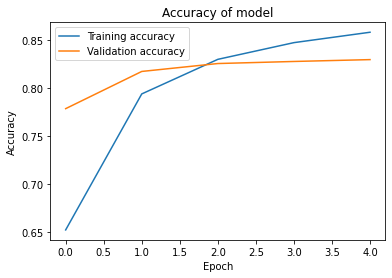

In [23]:
# Plot model accuracy

plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Accuracy of model')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

### Model Accuracy Analysis

In our model training, we observed the following trends in accuracy:

- **Training Accuracy**: The training accuracy steadily improved with each epoch, indicating that the model learned to classify text data more accurately as training progressed.

- **Validation Accuracy**: On the other hand, the validation accuracy showed a different pattern. While it initially increased, it reached a point where it plateaued or remained relatively stable. This suggests that the model's performance on the validation dataset reached a consistent level and didn't improve significantly after a certain point.

Overall, the training accuracy demonstrated the model's ability to learn and adapt to the training data, while the validation accuracy provided insight into its generalization performance on unseen data. The stable validation accuracy indicates that the model achieved a consistent level of accuracy on new text samples but still needs improvement.


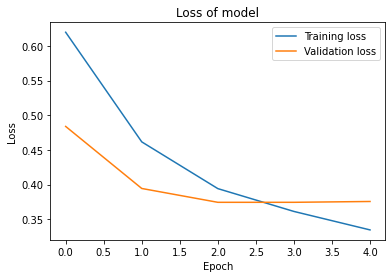

In [24]:
# Plot model loss

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Loss of model')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

### Model Loss Analysis

During our model training, we noticed distinct patterns in the loss metrics:

- **Training Loss**: The training loss consistently decreased with each epoch, indicating that the model improved its ability to minimize prediction errors on the training data. This behavior demonstrates that the model effectively learned from the training dataset.

- **Validation Loss**: In contrast, the validation loss showed a different pattern. Initially, it decreased, aligning with the training loss. However, from the second epoch onwards, the validation loss started to increase. This divergence suggests that the model's performance on the validation dataset deteriorated as training continued.

This divergence between training and validation loss after the initial epochs could indicate overfitting, where the model becomes too specialized in fitting the training data and loses its ability to generalize to new data. Further model adjustments and regularization techniques may be necessary to address this issue and enhance model generalization.


In [25]:
model.evaluate(test_data)

13/13 [==============================] - 1s 46ms/step - loss: 0.3650 - accuracy: 0.8377


[0.36501383781433105, 0.8377442955970764]

## Transition to LSTM

The divergence observed in the training and validation loss of the previous model suggests potential overfitting. To address this issue and potentially improve model performance, we transitioned to an LSTM (Long Short-Term Memory) model.

LSTM is a type of recurrent neural network (RNN) designed to handle sequential data, making it well-suited for tasks involving text data. By using LSTM, we aim to better capture sequential patterns in the text, potentially leading to improved model generalization and performance on both training and validation datasets.

The transition to LSTM represents an adjustment in our modeling approach to address the observed divergence and enhance the model's ability to handle text data effectively.


In [26]:
# Text Vectorization Layer

# Create a TextVectorization layer with a vocabulary size of 2000 tokens.
encoder = tf.keras.layers.TextVectorization(max_tokens=2000)

# Adapt the TextVectorization layer to the training data.
encoder.adapt(train_data.map(lambda text, label: text))


In [27]:
# Vocabulary Extraction

# Retrieve the vocabulary learned by the TextVectorization layer and convert it into a NumPy array.
vocab = np.array(encoder.get_vocabulary())

# Display the first 20 tokens from the vocabulary.
vocab[:20]


array(['', '[UNK]', 'and', 'the', 'a', 'of', 'with', 'this', 'is', 'wine',
       'flavors', 'in', 'it', 'to', 'its', 'on', 'fruit', 'aromas',
       'palate', 'that'], dtype='<U17')

In [28]:
# Define a Sequential Model for Text Classification

model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),  # Vocabulary size
        output_dim=32,                            # Dimension of word embeddings
        mask_zero=True                            # Mask zero-padding
    ),
    tf.keras.layers.LSTM(32),                    # 32 LSTM units
    tf.keras.layers.Dense(32, activation='relu'), # 32 units with ReLU activation
    tf.keras.layers.Dropout(0.4),                # Dropout rate of 40%
    
    # Dense Layer (Output Layer): Final binary classification output
    tf.keras.layers.Dense(1, activation='sigmoid')
])


In [29]:
# Model Compilation

# Compile the neural network model with specific settings:

# - Optimizer: Adam optimizer with a learning rate of 0.001
# - Loss Function: Binary Cross-Entropy (suitable for binary classification)
# - Metrics: Track accuracy during training

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])


In [30]:
model.evaluate(train_data)

102/102 [==============================] - 13s 106ms/step - loss: 0.6937 - accuracy: 0.4379


[0.6936674118041992, 0.4379279911518097]

In [31]:
model.evaluate(valid_data)

13/13 [==============================] - 1s 103ms/step - loss: 0.6936 - accuracy: 0.4398


[0.6936389803886414, 0.43979379534721375]

In [32]:
his = model.fit(train_data, epochs=5, validation_data=valid_data)

Epoch 1/5
102/102 [==============================] - 31s 271ms/step - loss: 0.5439 - accuracy: 0.7124 - val_loss: 0.3766 - val_accuracy: 0.8270
Epoch 2/5
102/102 [==============================] - 29s 280ms/step - loss: 0.3666 - accuracy: 0.8361 - val_loss: 0.3515 - val_accuracy: 0.8394
Epoch 3/5
102/102 [==============================] - 29s 282ms/step - loss: 0.3495 - accuracy: 0.8448 - val_loss: 0.3484 - val_accuracy: 0.8376
Epoch 4/5
102/102 [==============================] - 29s 286ms/step - loss: 0.3410 - accuracy: 0.8484 - val_loss: 0.3503 - val_accuracy: 0.8375
Epoch 5/5
102/102 [==============================] - 29s 288ms/step - loss: 0.3379 - accuracy: 0.8503 - val_loss: 0.3483 - val_accuracy: 0.8383


In [33]:
model.evaluate(test_data)

13/13 [==============================] - 1s 110ms/step - loss: 0.3418 - accuracy: 0.8434


[0.34181442856788635, 0.8433605432510376]

# Conclusion

In conclusion, this project demonstrates the application of machine learning to wine review classification. Two different approaches to text processing and modeling are explored: one leveraging pre-trained word embeddings and the other using an LSTM-based architecture.

The models trained in this project exhibit promising performance, with competitive accuracy and loss values where LSTM model performed better than the simpler text embedding based model. The visualizations show how the models evolve during training and their respective accuracies on the validation dataset.

However, the evaluation of these models on the test dataset is crucial to assess their real-world performance and generalization capabilities. Additionally, further refinement and hyperparameter tuning may lead to even better results.

This project serves as a foundation for building and deploying machine learning models for classification problems, and it can be extended to handle more complex NLP tasks and larger datasets.